In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table

### Pandas
import pandas as pd

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 30})

### Functions used in this code
import age_functions as afunc
import extinction as extinct
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757} # mircons

### Stuff Writtten by A Really Cool Professor
from dlnpyutils import utils as dln

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

<font size='45'>
    <b>
        Import Data
    </b>
</font>

# PARSEC Isochrones

In [2]:
# 12 Gyr
parsec12e9 = pd.read_csv('/Users/joshuapovick/Desktop/Research/parsec/parsec12e9.dat',comment='#',
                     names=["Zini","MH","logAge","Mini","int_IMF","Mass","logL","logTe","logg","label","McoreTP",
                            "C_O","period0","period1","period2","period3","period4","pmode","Mloss","tau1m","X",
                            "Y","Xc","Xn","Xo","Cexcess","Z","mbolmag","Gmag","G_BPmag","G_RPmag","B_Tmag",
                            "V_Tmag","Jmag","Hmag","Ksmag"],sep='\s+')

parsec12e9 = Table.from_pandas(parsec12e9)
parsec12e9 = parsec12e9[np.where(parsec12e9['label']==3)]

# 5 Gyr
parsec5e9 = pd.read_csv('/Users/joshuapovick/Desktop/Research/parsec/parsec5e9.dat',comment='#',
                     names=["Zini","MH","logAge","Mini","int_IMF","Mass","logL","logTe","logg","label","McoreTP",
                            "C_O","period0","period1","period2","period3","period4","pmode","Mloss","tau1m","X",
                            "Y","Xc","Xn","Xo","Cexcess","Z","mbolmag","Gmag","G_BPmag","G_RPmag","B_Tmag",
                            "V_Tmag","Jmag","Hmag","Ksmag"],sep='\s+')

parsec5e9 = Table.from_pandas(parsec5e9)
parsec5e9 = parsec5e9[np.where(parsec5e9['label']==3)]

# massive parsec file
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
massive = massive[np.where(massive['label']==3.0)]

# Globular Clusters

In [3]:
### GCS Data
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits')
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = Table(gcs[cln])

### Add Harris Distances to gcs file
harris_dist = [4.5,4.4,6.4,4.8,7.1,10.4,8.8,11.5,3.2,10.2,2.2,7.5,17.9,26.5,5.4,10.3,4.0,12.9,8.3,12.1,9.6,8.9,
               4.9,8.6,19.3,17.4,16.0,8.9,30.5,9.5,5.9,10.4,9.9,2.3,11.6,7.7,3.0,10.9,8.1,8.7,4.0,7.4,23.2,5.8,
               8.2,7.1,10.9,5.2]
harris_ebv = [0.04,0.28,0.33,0.19,0.02,0.10,0.38,0.10,0.34,0.01,0.35,0.03,0.02,0.15,0.08,0.05,0.25,0.01,0.02,0.02,
              0.22,0.03,0.24,0.05,0.02,0.01,0.00,0.36,0.01,0.36,0.54,0.54,0.37,0.18,0.47,0.48,0.76,0.53,0.40,0.05,
              0.04,0.77,0.03,1.46,1.24,1.76,1.17,0.12]

gcs['harris_dist'] = np.zeros(len(gcs))
gcs['harris_ebv'] = -9999.0*np.ones(len(gcs))

for i in range(len(np.unique(gcs['CLUSTER']))):
    clus = np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])
    gcs['harris_dist'][clus] = harris_dist[i]
    gcs['harris_ebv'][clus] = harris_ebv[i]

In [4]:
### Find Cluster with more than one star

idx = []
for i in range(len(np.unique(gcs['CLUSTER']))):
    idx.append(np.squeeze(np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])))

for i in range(len(idx)):
    try:
        len(idx[i])
    except:
        print('bad: ',i)

bad:  24
bad:  27
bad:  37


In [5]:
### Find Clusters with more than 10 stars

good_names = []
for i in np.asarray(idx)[np.delete(np.asarray(list(range(len(idx)))),[24,27,37])]:
    if len(i)>10:
        good_names.append(gcs['CLUSTER'][i][0])

print(good_names)

['47Tuc', 'M10', 'M107', 'M12', 'M13', 'M19', 'M2', 'M22', 'M3', 'M4', 'M5', 'M53', 'M54', 'M55', 'M71', 'M79', 'NGC1851', 'NGC2808', 'NGC288', 'NGC3201', 'NGC362', 'NGC6388', 'NGC6397', 'NGC6752', 'omegaCen']


In [6]:
### Keep only Clusters with more than 10 members

good_clus = np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
                     (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M19')|
                     (gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|(gcs['CLUSTER']=='M3')|
                     (gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|(gcs['CLUSTER']=='M53')|
                     (gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|(gcs['CLUSTER']=='M71')|
                     (gcs['CLUSTER']=='M79')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
                     (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
                     (gcs['CLUSTER']=='NGGC6388')|(gcs['CLUSTER']=='NGC6397')|(gcs['CLUSTER']=='NGC6752')|
                     (gcs['CLUSTER']=='omegaCen'))

gcs = gcs[good_clus]

Cluster:  M3


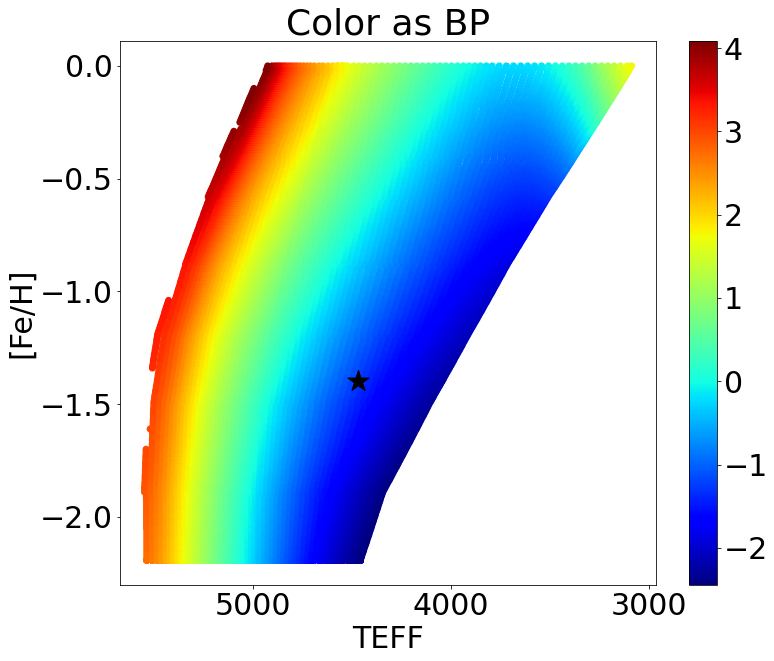

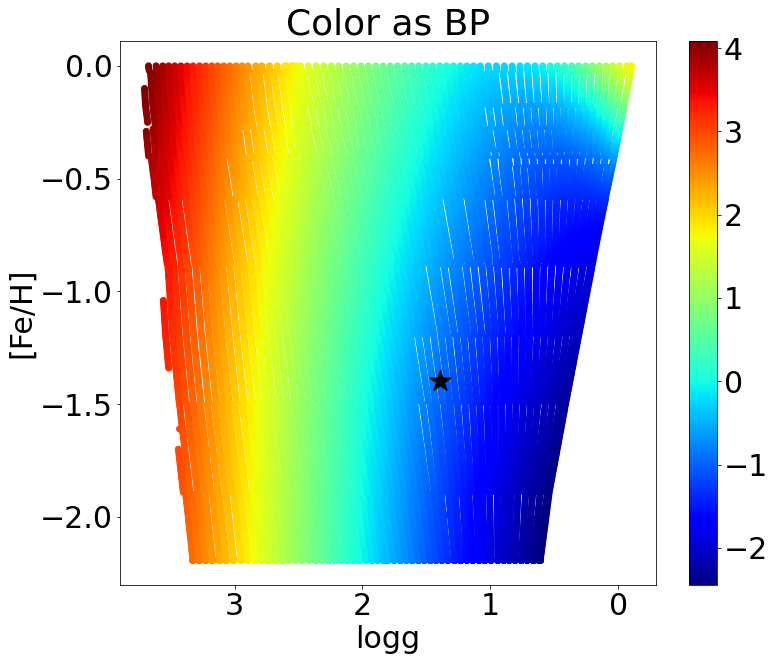

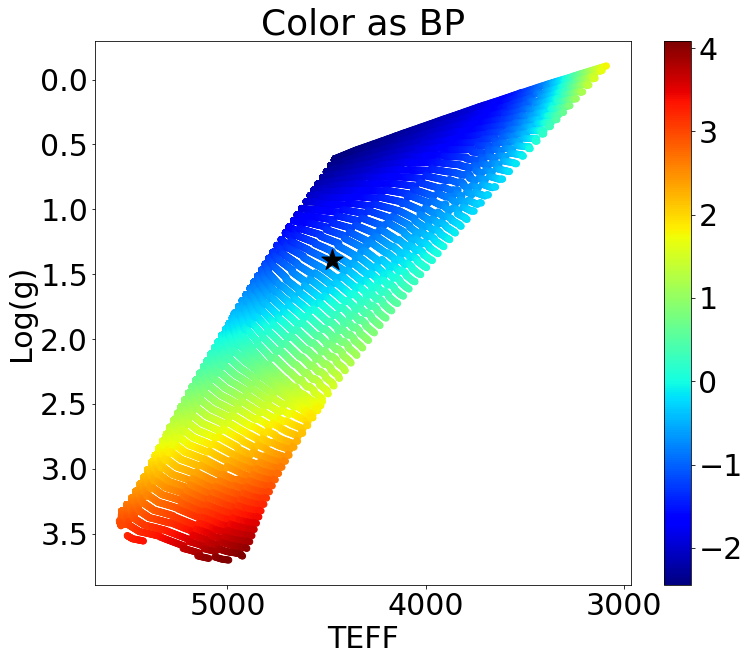

In [7]:
### Real Random Star 

'''
Isochrones in the following plots are 12 Gyr
'''

g_idx = 1000
# g_idx = 253
print('Cluster: ',gcs['CLUSTER'][g_idx])

### Teff [Fe/H] Relationship
plt.figure(figsize=[12,10])
plt.scatter(10**parsec12e9['logTe'],parsec12e9['MH'],c=parsec12e9['G_BPmag'],cmap='jet')
plt.colorbar()
plt.scatter(gcs['TEFF'][g_idx],gcs['FE_H'][g_idx],c='k',marker='*',s=500)
plt.gca().invert_xaxis()
plt.xlabel(r'TEFF')
plt.ylabel(r'[Fe/H]')
plt.title(r'Color as BP')
plt.show()

### LOGG [Fe/H] Relationship
plt.figure(figsize=[12,10])
plt.scatter(parsec12e9['logg'],parsec12e9['MH'],c=parsec12e9['G_BPmag'],cmap='jet')
plt.colorbar()
plt.scatter(gcs['LOGG'][g_idx],gcs['FE_H'][g_idx],c='k',marker='*',s=500)
plt.gca().invert_xaxis()
plt.xlabel(r'logg')
plt.ylabel(r'[Fe/H]')
plt.title(r'Color as BP')
plt.show()

### HR diagram
plt.figure(figsize=[12,10])
plt.scatter(10**parsec12e9['logTe'],parsec12e9['logg'],c=parsec12e9['G_BPmag'],cmap='jet')
plt.colorbar()
plt.scatter(gcs['TEFF'][g_idx],gcs['LOGG'][g_idx],c='k',marker='*',s=500)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'TEFF')
plt.ylabel(r'Log(g)')
plt.title(r'Color as BP')
plt.show()

<font size='45'>
    <b>
        Find an Age
    </b>
</font>

BP-RP, 
RP-J, 
J-H, 
H-K

# Find Extinction

In [10]:
bprp_int = extinct.parsec_teff2color(gcs[g_idx]['TEFF'],gcs[g_idx]['FE_H'],'G_BPmag','G_RPmag',12.5,parsec12e9)
# rpj_int = extinct.parsec_teff2color(gcs[g_idx]['TEFF'],gcs[g_idx]['FE_H'],'G_RPmag','Jmag',12.5,parsec12e9)
# jh_int = extinct.parsec_teff2color(gcs[g_idx]['TEFF'],gcs[g_idx]['FE_H'],'Jmag','Hmag',12.5,parsec12e9)
# hk_int = extinct.parsec_teff2color(gcs[g_idx]['TEFF'],gcs[g_idx]['FE_H'],'Hmag','Ksmag',12.5,parsec12e9)
# jk_int = extinct.parsec_teff2color(gcs[g_idx]['TEFF'],gcs[g_idx]['FE_H'],'Jmag','Ksmag',12.5,parsec12e9)

ebprp = (gcs['GAIA_PHOT_BP_MEAN_MAG']-gcs['GAIA_PHOT_RP_MEAN_MAG'])[g_idx]-bprp_int
# erpj = (gcs['GAIA_PHOT_RP_MEAN_MAG']-gcs['J'])[g_idx]-rpj_int
# ejh = (gcs['J']-gcs['H'])[g_idx]-jh_int
# ehk = (gcs['H']-gcs['K'])[g_idx]-hk_int
# ejk = (gcs['J']-gcs['K'])[g_idx]-jk_int

# akejk = extinct.cardelli_alav(leff['K'],3.1)/extinct.cardelli_e12av(leff['J'],leff['K'],3.1)

# ak = ejk*akejk
arp = ebprp* extinct.cardelli_alav(leff['RP'],3.1)/extinct.cardelli_e12av(leff['BP'],leff['RP'],3.1)
arp

0.06047651900198667

In [12]:
#########################
### Modified Versions ### 
#########################

'''
Modified versions of functions in extinction.py

Trying to mess around to figure out selection that's not quite right

'''


from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator
from photutils.utils import ShepardIDWInterpolator as idw

def closest(val,dat):
    '''
    find value closest to the given one
    
    Inputs:
    ------
        val: given value to find/get closest to
        dat: vals to search through
    
    Output:
    
    ------
        value in dat closest to val
    '''
    val = np.asarray(val)
    dat = np.asarray(dat)
    
    abs_diff = np.abs(dat - val)
    return dat[abs_diff.argmin()]

############################################################################
### Functions to calulate intrinsic magnitude from teff, [Fe/H] and logg ###
############################################################################

def mag_int_near(lgteff,feh,lgg,band,age,parsec):
    '''
    Calculate the intrinsic magnitude of a star using spectroscopic properties and 
    PARSEC isochrones using nearest neighbors
    
    Inputs:
    ------
        lgteff: log(Teff) of star
        feh: [Fe/H] of star
        lgg: log(g) for star
        band: photometry band of interest
        feh: metallicity of star
        age: age in Gyr
        parsec: set of parsec isochrones
    
    Outputs:
    -------
        mag: intrinsic magnitude of star
    '''
    age = np.log10(age*10**9) 
    age_select = np.where((parsec['logAge']==closest(age,parsec['logAge']))&
                          (parsec['MH']==closest(feh,parsec['MH'])))
#     age_select = np.where((parsec['logAge']==closest(age,parsec['logAge']))&
#                           (parsec['logTe']==closest(lgteff,parsec['logTe']))&
#                           (parsec['MH']==closest(feh,parsec['MH'])))
    iso = np.array([parsec['logTe'][age_select],parsec['MH'][age_select],parsec['logg'][age_select]]).T
    interp = NearestNDInterpolator(iso,parsec[band][age_select])
    
    mag = interp([lgteff,feh,lgg])
    
    return mag

def mag_int_lin(lgteff,feh,lgg,band,age,parsec):
    '''
    Calculate the intrinsic magnitude of a star using spectroscopic properties and 
    PARSEC isochrones using linear interpolation
    
    Inputs:
    ------
        lgteff: log(Teff) of star
        feh: [Fe/H] of star
        lgg: log(g) for star
        band: photometry band of interest
        feh: metallicity of star
        age: age in Gyr
        parsec: set of parsec isochrones
    
    Outputs:
    -------
        mag: intrinsic magnitude of star
    '''
    age = np.log10(age*10**9) 
    age_select = np.where((parsec['logAge']==closest(age,parsec['logAge']))&
                          (parsec['MH']==closest(feh,parsec['MH'])))
#     age_select = np.where((parsec['logAge']==closest(age,parsec['logAge']))&
#                           (parsec['logTe']==closest(lgteff,parsec['logTe']))&
#                           (parsec['MH']==closest(feh,parsec['MH'])))
    iso = np.array([parsec['logTe'][age_select],parsec['MH'][age_select],parsec['logg'][age_select]]).T
    interp = LinearNDInterpolator(iso,parsec[band][age_select])
    
    mag = interp([lgteff,feh,lgg])
    
    return mag

def mag_int_idw(lgteff,feh,lgg,band,age,parsec):
    '''
    Calculate the intrinsic magnitude of a star using spectroscopic properties and 
    PARSEC isochrones using Shepard's method interpoaltion
    
    Inputs:
    ------
        lgteff: log(Teff) of star
        feh: [Fe/H] of star
        lgg: log(g) for star
        band: photometry band of interest
        feh: metallicity of star
        age: age in Gyr
        parsec: set of parsec isochrones
    
    Outputs:
    -------
        mag: intrinsic magnitude of star
    '''
    age = np.log10(age*10**9) 
    age_select = np.where((parsec['logAge']==closest(age,parsec['logAge']))&
                          (parsec['MH']==closest(feh,parsec['MH'])))
#     age_select = np.where((parsec['logAge']==closest(age,parsec['logAge']))&
#                           (parsec['logTe']==closest(lgteff,parsec['logTe']))&
#                           (parsec['MH']==closest(feh,parsec['MH'])))
    iso = np.array([parsec['logTe'][age_select],parsec['MH'][age_select],parsec['logg'][age_select]]).T
    interp = idw(iso,parsec[band][age_select])
    
    mag = interp([lgteff,feh,lgg])
    
    return mag

In [13]:
'''
Calculate expected magnitude for all unique ages in the massive table
'''

RP_int_near = []
RP_int_lin = []
RP_int_idw = []

for i in tqdm_notebook(10**np.unique(massive['logAge'])/10**9):
    RP_int_near.append(mag_int_near(np.log10(gcs['TEFF'][g_idx]),
                                    gcs['FE_H'][g_idx],gcs['LOGG'][g_idx],'G_RPmag',i,massive))
    
    ### Linear interpolation not working
#     RP_int_lin.append(mag_int_lin(np.log10(gcs['TEFF'][g_idx]),
#                                     gcs['FE_H'][g_idx],gcs['LOGG'][g_idx],'G_RPmag',i,massive))

    RP_int_idw.append(mag_int_idw(np.log10(gcs['TEFF'][g_idx]),
                                    gcs['FE_H'][g_idx],gcs['LOGG'][g_idx],'G_RPmag',i,massive))

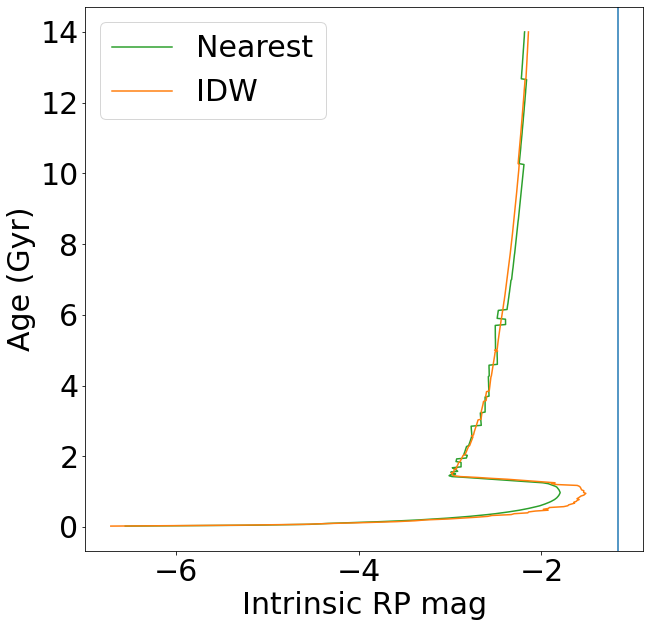

In [17]:
'''
Seeing where gcs[1000] the star falls on the plot after account for its distance and Cardelli extinction
'''

plt.figure(figsize=[10,10])
plt.plot(np.asarray(RP_int_near).flatten(),10**np.unique(massive['logAge'])/10**9,label='Nearest',c='tab:green')
# plt.plot(np.asarray(RP_int_lin).flatten(),10**np.unique(massive['logAge'])/10**9,label='Linear',c='tab:red')
plt.plot(np.asarray(RP_int_idw).flatten(),10**np.unique(massive['logAge'])/10**9,label='IDW',c='tab:orange')
plt.axvline(gcs['GAIA_PHOT_BP_MEAN_MAG'][g_idx]-(5*np.log10(10000)-5)-arp)
plt.legend()
plt.xlabel(r'Intrinsic RP mag')
plt.ylabel(r'Age (Gyr)')
plt.savefig('randomstar_agemag.pdf',bbox_inches='tight')
plt.show()

Text(0, 0.5, 'Age (Gyr)')

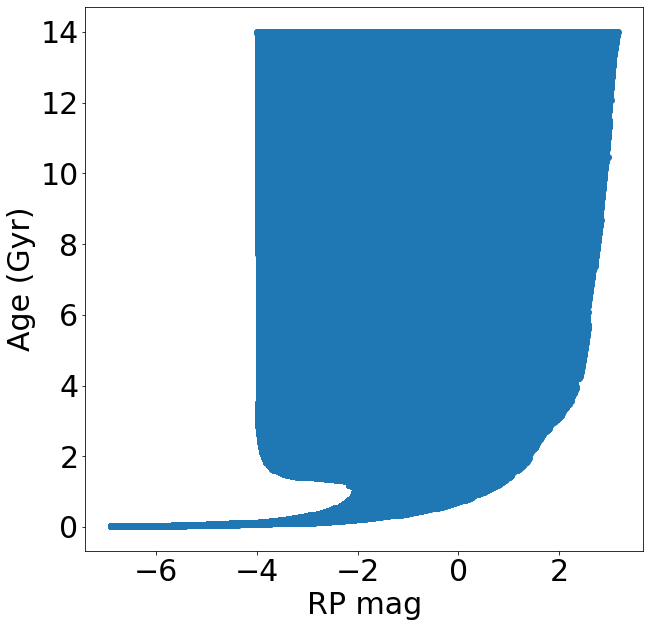

In [15]:
'''
Can see funky stuff for ages less than 2 Gyr without any select (other than RGB points only)
'''
plt.figure(figsize=[10,10])
plt.scatter(massive['G_RPmag'],10**massive['logAge']/10**9)
plt.xlabel('RP mag')
plt.ylabel('Age (Gyr)')